# # China → US Spillover Analysis (Jupyter Notebook)
# Simple, well-commented notebook that tests whether Chinese indices help predict US index returns.
# Assumes your CSVs already have columns: Date, Close, Idxrtn (so no renaming required).


### Quick overview
# Steps:
# 1. Load weekly data (assume weekly or resample to weekly)
# 2. Compute weekly log returns
# 3. Method A: VAR + Granger causality (lead-lag testing)
# 4. Method B: Diebold-Yilmaz spillover index (FEVD-based)
# 5. Method C: Volatility spillover via GARCH + rolling correlation of standardized residuals
# 6. Method D: ML-approach: XGBoost
# 7. Method E: ML-approach: small feed-forward neural net

## Setup

In [10]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached grpcio-1.76.0-cp313-cp313-macosx_11_0_universal2.whl.metadata (3.7 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-

In [2]:
pip install pandas numpy matplotlib seaborn statsmodels arch xgboost tensorflow

  Using cached statsmodels-0.14.5-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached arch-8.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached termco

In [2]:
pip install statsmodels arch xgboost tensorflow scikit-learn seaborn


  Using cached statsmodels-0.14.5-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.5 kB)
  Using cached arch-8.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
Using cached statsmodels-0.14.5-cp313-cp313-macosx_11_0_arm64.whl (9.7 MB)
Using cached arch-8.0.0-cp313-cp313-macosx_11_0_arm64.whl (930 kB)
Using cached xgboost-3.1.1-py3-none-macosx_12_0_arm64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [arch]3/4 [arch]models]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




sns.set_style('whitegrid')
np.random.seed(42)

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from arch import arch_model


from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [2]:
us = pd.read_csv('Project/us_index.csv', parse_dates=['Date']).sort_values('Date')
cn = pd.read_csv('Project/cn_index.csv', parse_dates=['Date']).sort_values('Date')

us_w = us.set_index('Date')['Close']   # keine Resample nötig
cn_w = cn.set_index('Date')['Close']

Sample rows:
        Date  US_Close  CN_Close    US_Ret    CN_Ret
0 2005-01-14   2087.91   1245.62 -0.000335  0.000699
1 2005-01-21   2034.27   1234.48 -0.026027 -0.008984
2 2005-01-28   2035.83   1213.67  0.000767 -0.017001
3 2005-02-04   2086.66   1269.00  0.024661  0.044580
4 2005-02-11   2076.66   1269.00 -0.004804  0.000000


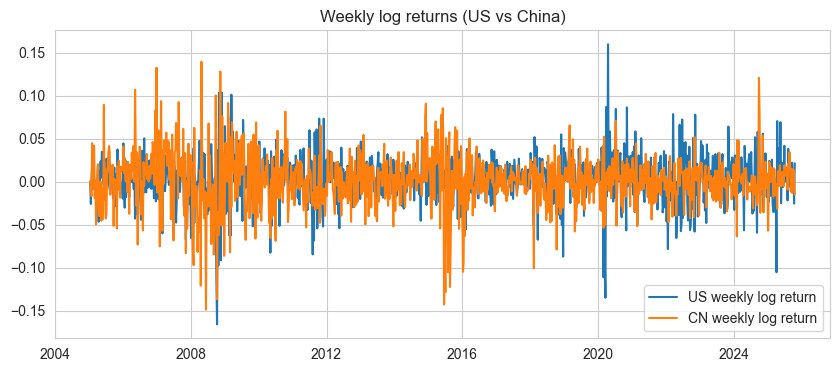

In [3]:



# Resample both series to weekly (Friday close). If your data is already weekly, this will simply keep it.
us_w = us.set_index('Date')['Close'].resample('W-FRI').last().ffill()
cn_w = cn.set_index('Date')['Close'].resample('W-FRI').last().ffill()


# Build DataFrame with log returns
data = pd.DataFrame({'US_Close': us_w, 'CN_Close': cn_w}).dropna()
# Log returns: simple and commonly used for VAR / GARCH
data['US_Ret'] = np.log(data['US_Close']).diff()
data['CN_Ret'] = np.log(data['CN_Close']).diff()
# drop the first NA after differencing
data = data.dropna().reset_index().rename(columns={'index': 'Date'})


print('Sample rows:')
print(data.head())


plt.figure(figsize=(10,4))
plt.plot(data['Date'], data['US_Ret'], label='US weekly log return')
plt.plot(data['Date'], data['CN_Ret'], label='CN weekly log return')
plt.legend()
plt.title('Weekly log returns (US vs China)')
plt.show()



In [4]:
# %%
# Prepare data and fit VAR
var_data = data[['US_Ret', 'CN_Ret']].set_index(data['Date'])
model = VAR(var_data)
res = model.fit(4)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Oct, 2025
Time:                     20:26:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.0560
Nobs:                     1080.00    HQIC:                  -14.1076
Log likelihood:           4588.21    FPE:                7.23543e-07
AIC:                     -14.1391    Det(Omega_mle):     7.11633e-07
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002285         0.000857            2.665           0.008
L1.US_Ret        -0.049458         0.031142           -1.588           0.112
L1.CN_Ret        -0.043015         0.027951           -1.539           0.12

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


## Methods

### Granger Causality

Idea (simple): fit a VAR on the two return series and run Granger causality tests.
If lagged CN returns help predict US returns (statistically), that is evidence of return spillover from CN to US.


Notes on interpretation:
- Granger causality is not proof of economic causation. It tests whether past values of one series contain predictive information about another.
- Use several lags. Here we use 4 weekly lags (~1 month).


In [5]:
# Prepare data and fit VAR
var_data = data[['US_Ret', 'CN_Ret']].set_index(data['Date'])
model = VAR(var_data)
res = model.fit(4)
print(res.summary())

# The function expects an array where column 0 is the dependent variable
# and column 1 is the potential cause. We test both directions.
print('Granger test: does CN cause US? (null: no causality)')
grangercausalitytests(var_data[['US_Ret','CN_Ret']], maxlag=4, verbose=True)


print('Granger test: does US cause CN? (null: no causality)')
grangercausalitytests(var_data[['CN_Ret','US_Ret']], maxlag=4, verbose=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Oct, 2025
Time:                     20:26:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.0560
Nobs:                     1080.00    HQIC:                  -14.1076
Log likelihood:           4588.21    FPE:                7.23543e-07
AIC:                     -14.1391    Det(Omega_mle):     7.11633e-07
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002285         0.000857            2.665           0.008
L1.US_Ret        -0.049458         0.031142           -1.588           0.112
L1.CN_Ret        -0.043015         0.027951           -1.539           0.12

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


{np.int64(1): ({'ssr_ftest': (np.float64(18.246463080185187),
    np.float64(2.1118391795043864e-05),
    np.float64(1080.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(18.297147699852367),
    np.float64(1.8898992480170294e-05),
    np.int64(1)),
   'lrtest': (np.float64(18.144302832120957),
    np.float64(2.0478116034061885e-05),
    np.int64(1)),
   'params_ftest': (np.float64(18.246463080185436),
    np.float64(2.11183917950382e-05),
    np.float64(1080.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(11.34525097236939),
    np.float64(1.3304726331267783e-05),
    np.float64(1077.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(22.79584317939402),
    np.float64(1.1218777851464502e-05),
    np.int64(2)),
   'lrtest': (np.float64(22.559029346077295),
    np.float64(1.2629001619815764e-05),
    np.int64(2)),
   'params_ftest': (np.float64(11.345250972368754),
    np.float64(1.3304726331276787e-05),
    np.float64(1077.0),
    2.0)},
   arr

### Diebold-Yilmaz spillover index
Idea: use the VAR's forecast error variance decomposition (FEVD). The fraction of US forecast error variance
explained by shocks to CN (the off-diagonal element) is a direct measure of spillover from CN to US.


This is a simplified one-step FEVD approach. Robust research implementations use generalized FEVD and
bootstrap inference. This version is for learning and quick checks.


In [18]:
import numpy as np
import pandas as pd

h = 10  # Horizont

# --- Alles in NumPy konvertieren ---
Psi = res.ma_rep(maxn=h-1)
Psi = np.asarray(Psi)                 # (h, k, k)

Sigma = res.sigma_u
Sigma = np.asarray(Sigma)             # (k, k)

k = Psi.shape[1]
sigma_diag = np.diag(Sigma).astype(float)   # (k,)

num = np.zeros((k, k), dtype=float)
den = np.zeros(k, dtype=float)

for s in range(h):
    Ps = Psi[s]                        # (k, k)
    B  = Ps @ Sigma                    # (k, k)
    # Zähler: elementweise Quadrat, geteilt durch Varianz der j-ten Innovation (Broadcast über Spalten)
    num += (B * B) / sigma_diag[np.newaxis, :]

    # Nenner: diag(Ps Σ Ps')  -> effizient als Zeilensummen von (B ⊙ Ps)
    den += np.sum(B * Ps, axis=1)

# Reihenweise Anteile
# (ohne [:, None], falls trotzdem Probleme: den = den.reshape(-1, 1))
GFEVD = num / den.reshape(-1, 1)

# Zeilen auf 1 normieren
row_sums = GFEVD.sum(axis=1, keepdims=True)
GFEVD = GFEVD / row_sums

off_diag = GFEVD.sum() - np.trace(GFEVD)
total_spill = off_diag / k
print(f"Total spillover index (h={h}): {total_spill:.4f}")

labels = ['US','CN'][:k]
spill_df = pd.DataFrame(GFEVD,
                        index=[f"{l}_recipient" for l in labels],
                        columns=[f"{l}_source" for l in labels])
print("\nFEVD share matrix (rows = recipient, cols = source):")
print(spill_df.round(4))


Total spillover index (h=10): 0.0519

FEVD share matrix (rows = recipient, cols = source):
              US_source  CN_source
US_recipient     0.9576     0.0424
CN_recipient     0.0613     0.9387


In [ ]:
# h = 10  # FEVD horizon in periods (weeks)
# fevd = res.fevd(h)
# # fevd.decomp: shape (h, neqs, neqs) — take the last horizon
# try:
#     decomp = fevd.decomp[-1]
# except Exception:
#     # statsmodels versions differ; fall back to direct attribute
#     decomp = fevd._decomp[-1]

# # normalize rows to sum to 1 (so we interpret as shares)
# row_sums = decomp.sum(axis=1, keepdims=True)
# shares = decomp / row_sums

# # total spillover index: mean of off-diagonal shares
# n = shares.shape[0]
# off_diag = shares.sum() - np.trace(shares)
# total_spill = off_diag / n
# print(f'Total spillover index (h={h}): {total_spill:.4f}')

# # create labeled DataFrame of variance shares
# spill_df = pd.DataFrame(shares, index=['US_recipient','CN_recipient'], columns=['US_source','CN_source'])
# print('FEVD share matrix (rows = recipient, cols = source):')
# print(spill_df)


Total spillover index (h=10): 0.9020


ValueError: Shape of passed values is (10, 2), indices imply (2, 2)

## 5. Method C: Volatility spillover (GARCH + rolling correlation of standardized residuals)
Idea: Fit univariate GARCH(1,1) to each return series to model conditional volatility.
Then compute standardized residuals (residual / cond. vol). If those standardized residuals show
time-varying correlation (e.g., rising after shocks), that is suggestive of volatility spillover / contagion.


This is a clear, easy-to-implement proxy. For full multivariate modeling use DCC-GARCH or BEKK.

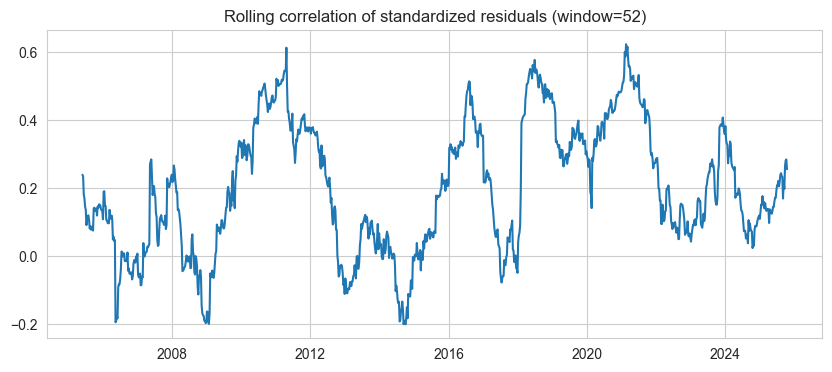

Average rolling correlation: 0.1998


In [11]:
# Fit GARCH(1,1) to each returns series (scale returns because small numbers can cause numerical issues)
us_garch = arch_model(data['US_Ret']*100, p=1, q=1).fit(disp='off')
cn_garch = arch_model(data['CN_Ret']*100, p=1, q=1).fit(disp='off')


# standardized residuals
us_std = us_garch.resid / us_garch.conditional_volatility
cn_std = cn_garch.resid / cn_garch.conditional_volatility


# Rolling correlation of standardized residuals (window=52 weeks ~ 1 year)
roll_corr = us_std.rolling(window=52, min_periods=20).corr(cn_std)


plt.figure(figsize=(10,4))
# roll_corr aligns with the index of the original series (same length)
plt.plot(data['Date'], roll_corr)
plt.title('Rolling correlation of standardized residuals (window=52)')
plt.show()


print(f'Average rolling correlation: {roll_corr.mean():.4f}')

### Machine Learning

ML: Predict US returns using lagged China returns (XGBoost and small NN)
Build simple lag features and evaluate using time-series cross-validation to avoid look-ahead bias.

Rules used here:
- Use lagged CN returns (1..4) and optionally lagged US returns for autoregressive info
- Evaluate with TimeSeriesSplit, reporting RMSE and R^2

In [13]:
# Lags

def make_lags(df, lags=4):
    # df must have columns Date, US_Ret, CN_Ret
    tmp = df.copy().set_index('Date')
    for i in range(1, lags+1):
        tmp[f'CN_lag{i}'] = tmp['CN_Ret'].shift(i)
        tmp[f'US_lag{i}'] = tmp['US_Ret'].shift(i)
        tmp = tmp.dropna().reset_index()
        return tmp


lags = 4
ml_df = make_lags(data, lags=lags)
features = [c for c in ml_df.columns if 'lag' in c]
X = ml_df[features].values
y = ml_df['US_Ret'].values


print('ML sample size:', X.shape)
print('Features:', features)

ML sample size: (1083, 2)
Features: ['CN_lag1', 'US_lag1']


#### XGBoost
Simple regressor with default settings. TimeSeriesSplit prevents using future information.

In [15]:
tscv = TimeSeriesSplit(n_splits=5)
preds_xgb = np.zeros_like(y)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds_xgb[test_idx] = model.predict(X_test)


print('XGBoost RMSE:', np.sqrt(mean_squared_error(y, preds_xgb)))
print('XGBoost R2:', r2_score(y, preds_xgb))

XGBoost RMSE: 0.03274849056381361
XGBoost R2: -0.38786105767940926


#### Neural Network
Small fully connected network. We scale features and keep architecture tiny to avoid overfitting on small samples.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
preds_nn = np.zeros_like(y)


for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    nn = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
nn.compile(optimizer='adam', loss='mse')
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=0)
nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0, callbacks=[es])
preds_nn[test_idx] = nn.predict(X_test).flatten()


print('NN RMSE:', np.sqrt(mean_squared_error(y, preds_nn)))
print('NN R2:', r2_score(y, preds_nn))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
NN RMSE: 0.028253062616317763
NN R2: -0.03298610365880217


#### ML methods evaluation

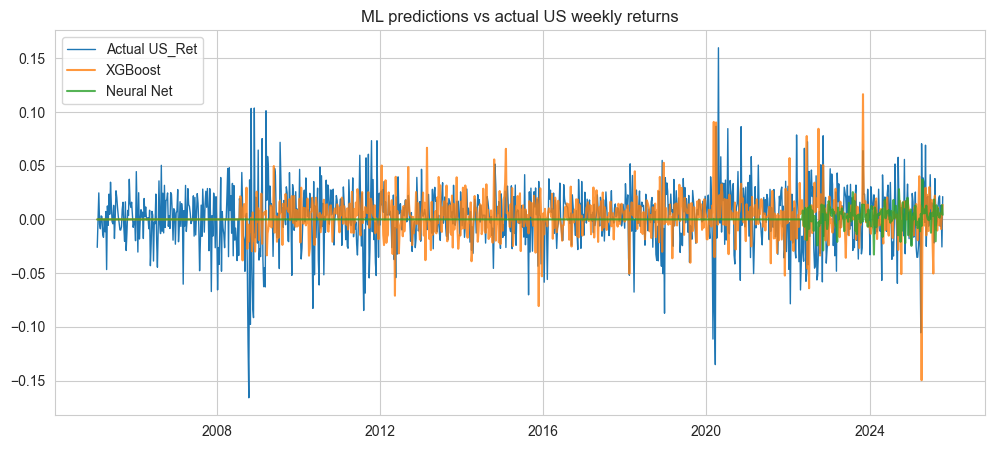

In [17]:
# Plot ML predictions vs. actual

plt.figure(figsize=(12,5))
plt.plot(ml_df['Date'], y, label='Actual US_Ret', linewidth=1)
plt.plot(ml_df['Date'], preds_xgb, label='XGBoost', alpha=0.8)
plt.plot(ml_df['Date'], preds_nn, label='Neural Net', alpha=0.8)
plt.legend()
plt.title('ML predictions vs actual US weekly returns')
plt.show()